In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_data(filename,train,calib,size):
        with h5py.File(filename, 'r', libver='v112') as h5_file_handle:
            if train:
              image_train=np.array(h5_file_handle["/train/image"])
              full_pose_train=np.array(h5_file_handle["/train/xyzyaw_relative"])
              led_status_train=np.array(h5_file_handle["/train/led_status"])
              image_points_y=np.array(h5_file_handle["/train/image_points_y"])
              image_points_x=np.array(h5_file_handle["/train/image_points_x"])
            else:
              image_train=np.array(h5_file_handle["/test/image"])
              full_pose_train=np.array(h5_file_handle["/test/xyzyaw_relative"])
              led_status_train=np.array(h5_file_handle["/test/led_status"])
              image_points_y=np.array(h5_file_handle["/test/image_points_y"])
              image_points_x=np.array(h5_file_handle["/test/image_points_x"])
        x=image_points_y.reshape((-1,1))
        y=image_points_y.reshape((-1,1))
        sz = 160
        X, Y = np.meshgrid(np.arange(sz),np.arange(sz))
        # out=np.empty((0,160,160), int)
        out =[]
        for element in range(image_points_y.shape[0]): 
          x, y = 150-image_points_y[element],160-image_points_x[element]
          D = ((X-x)**2 + (Y-y)**2)**0.5
          out_in=((1 - np.tanh((D-5)*0.08))/2).astype("float32")
          # out=np.append(out,out_in[None,:,:],axis=0)
          out.append(out_in[None,:,:])
        if(calib):
            im=image_train[0:size]
            dist=full_pose_train.reshape((-1,4))[:,0].reshape(-1,1)[0:size]
            led=led_status_train.reshape((-1,1))[0:size]
            out=np.array(out)[0:size]
        else:
            im=image_train
            dist=full_pose_train.reshape((-1,4))[:,0].reshape(-1,1)
            led=led_status_train.reshape((-1,1))
            out=np.array(out)
        print(im.shape)
        print(out.shape)
        led=np.tile(np.expand_dims(np.expand_dims(led, axis=-1), axis=-1), [1,160,160])
        dist=np.tile(np.expand_dims(np.expand_dims(dist, axis=-1), axis=-1), [1,160,160])
        print(dist.shape)
        print(led.shape)
        y_train=np.concatenate((np.concatenate((out,led),axis=1),dist),axis=1)
        print(y_train.shape)
        

        return [im,y_train]

In [4]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).int()
        self.y = torch.from_numpy(y).float()
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [5]:
Mcalib = 1024
calib_set = get_data("./content/datasets/dataset_train.h5",True,True,8192)
# train_set = get_data("./content/datasets/dataset_train.h5",True,False)
# train_dataset = MyDataset(train_set[0], train_set[1])
calib_dataset = MyDataset(calib_set[0], calib_set[1])
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
calib_dataloader = DataLoader(calib_dataset, batch_size=32, shuffle=True)

(8192, 1, 160, 160)
(8192, 1, 160, 160)
(8192, 1, 160, 160)
(8192, 1, 160, 160)
(8192, 3, 160, 160)


In [6]:
def test_plot(dataloader):
    fig, axs = plt.subplots(3, 4, figsize=(15, 12))
    axs = axs.flatten()
    for i, (x, y) in enumerate(dataloader):
        if i%2==1:
          if i >= 12:
              break
          axs[i-1].imshow(x[0][0],cmap="gray")
          axs[i].imshow(y[0][0])
          print("dist:",y[0][2][0][0])
    plt.tight_layout()
    plt.show()

dist: tensor(1.1110)
dist: tensor(0.6428)
dist: tensor(1.1274)
dist: tensor(1.7682)
dist: tensor(0.5889)
dist: tensor(1.3935)


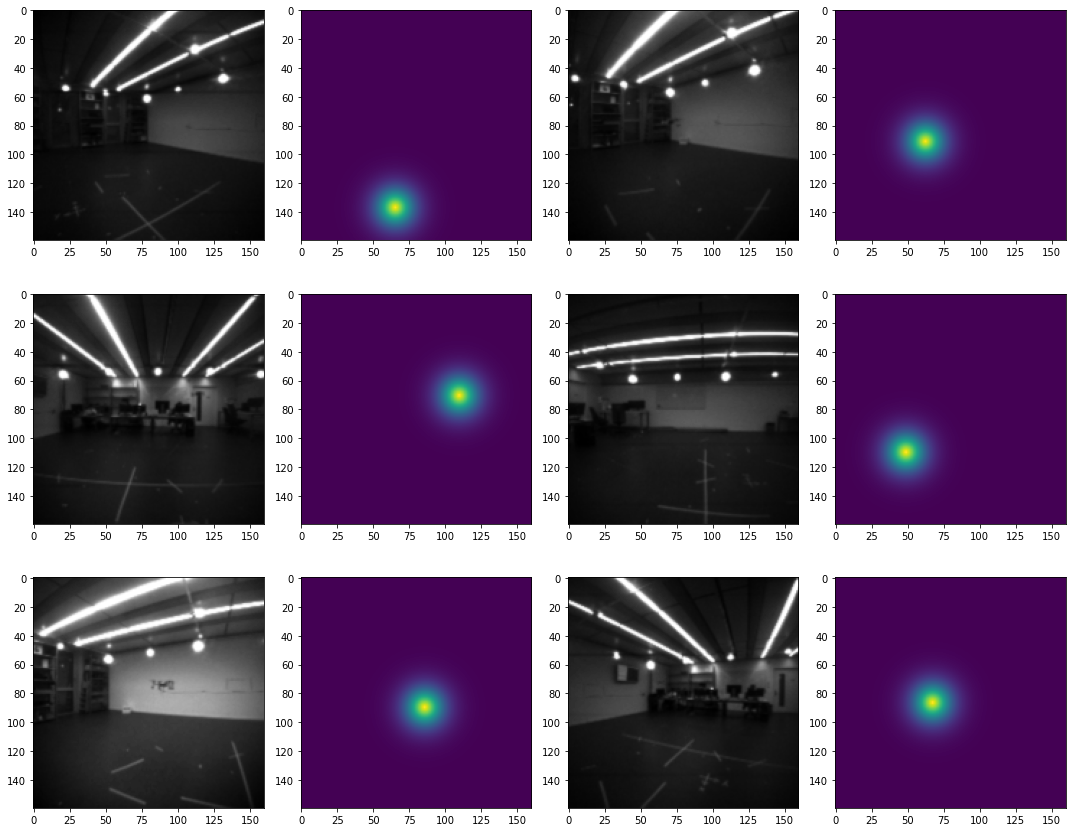

In [7]:
test_plot(calib_dataloader)

In [8]:
# class MkModel(nn.Module):
#     def __init__(self):
#         super(MkModel, self).__init__()
#         activation_class = nn.ReLU
#         self.block1 = MkModel.make_standard_convolution_layer(in_channels=1,out_channels=8,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.block2 = MkModel.make_standard_convolution_layer(in_channels=8,out_channels=16,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.poolconv1 = MkModel.make_standard_convolution_layer(in_channels=16,out_channels=16,kernel_size=2,padding=0,stride=2,activation_class=activation_class)
#         self.block3 = MkModel.make_standard_convolution_layer(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.poolconv2 = MkModel.make_standard_convolution_layer(in_channels=32,out_channels=32,kernel_size=2,padding=0,stride=2,activation_class=activation_class)
#         self.block4 = MkModel.make_standard_convolution_layer(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.poolconv3 = MkModel.make_standard_convolution_layer(in_channels=64,out_channels=64,kernel_size=2,padding=0,stride=2,activation_class=activation_class)
#         self.block5 = MkModel.make_standard_convolution_layer(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.block6 = MkModel.make_standard_convolution_layer(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1,activation_class=activation_class)
#         self.block7 = MkModel.make_standard_convolution_layer(in_channels=128,out_channels=3,kernel_size=3,padding=1,stride=1,activation_class=activation_class)

    
#     @staticmethod
#     def make_standard_convolution_layer(in_channels:      int,
#                                             out_channels:     int,
#                                             kernel_size:    int,
#                                             padding:      int,
#                                             stride:       int,
#                                             activation_class: type) -> nn.Sequential:

#             modules = []

#             modules += [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,padding=padding, bias=False)]
#             modules += [nn.BatchNorm2d(out_channels)]
#             modules += [activation_class(inplace=True)]

#             return nn.Sequential(*modules)
    
    
        
#     def forward(self, x):
#         x = self.block1(x)
# #         print(x.shape)
#         x = self.block2(x)
# #         print(x.shape)
#         x = self.poolconv1(x)
# #         print(x.shape)
#         x = self.block3(x)
# #         print(x.shape)
#         x = self.poolconv2(x)
# #         print(x.shape)
#         x = self.block4(x)
# #         print(x.shape)
#         x = self.poolconv3(x)
# #         print(x.shape)
#         x = self.block5(x)
# #         print(x.shape)
#         x = self.block6(x)
# #         print(x.shape)
#         x = self.block7(x)
# #         print(x.shape)
#         return x

In [9]:
# class MkModel(nn.Module):
#     def __init__(self):
#         super(MkModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.relu1 = nn.ReLU()
#         self.sep_conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.relu2 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool1 = nn.BatchNorm2d(16)
#         self.sep_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.relu3 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool2 = nn.BatchNorm2d(32)
#         self.sep_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.relu4 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool3 = nn.BatchNorm2d(64)
#         self.sep_conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.bn5 = nn.BatchNorm2d(128)
#         self.relu5 = nn.ReLU()
#         self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0)
#         self.bn6 = nn.BatchNorm2d(128)
#         self.relu6 = nn.ReLU()
#         self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
#         self.bn7 = nn.BatchNorm2d(3)
#         self.relu7 = nn.ReLU()
        
#     def forward(self, x):
#         x = self.relu1(self.bn1(self.conv1(x)))
#         x = self.relu2(self.bn2(self.sep_conv1(x)))
#         x = self.bn_pool1(self.pool1(x))
#         x = self.relu3(self.bn3(self.sep_conv2(x)))
#         x = self.bn_pool2(self.pool2(x))
#         x = self.relu4(self.bn4(self.sep_conv3(x)))
#         x = self.bn_pool3(self.pool3(x))
#         x = self.relu5(self.bn5(self.sep_conv4(x)))
#         x = self.relu6(self.bn6(self.conv2(x)))
#         x = self.relu7(self.bn7(self.conv3(x)))
        
#         return x

In [10]:
class MkModel(nn.Module):
    def __init__(self):
        super(MkModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.sep_conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.sep_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.sep_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.sep_conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        self.bn7 = nn.BatchNorm2d(3)
        self.relu7 = nn.ReLU()
        
    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.sep_conv1(x)))
        x = self.pool1(x)
        x = self.relu3(self.bn3(self.sep_conv2(x)))
        x = self.pool2(x)
        x = self.relu4(self.bn4(self.sep_conv3(x)))
        x = self.pool3(x)
        x = self.relu5(self.bn5(self.sep_conv4(x)))
        x = self.relu6(self.bn6(self.conv2(x)))
        x = self.relu7(self.bn7(self.conv3(x)))
        
        return x

In [11]:
# class MkModel(nn.Module):
#     def __init__(self):
#         super(MkModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.relu1 = nn.ReLU()
#         self.sep_conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.relu2 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool1 = nn.BatchNorm2d(16)
#         self.relupool1 = nn.ReLU()
#         self.sep_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.relu3 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool2 = nn.BatchNorm2d(32)
#         self.relupool2 = nn.ReLU()
#         self.sep_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.relu4 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
#         self.bn_pool3 = nn.BatchNorm2d(64)
#         self.relupool3 = nn.ReLU()
#         self.sep_conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.bn5 = nn.BatchNorm2d(128)
#         self.relu5 = nn.ReLU()
#         self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0)
#         self.bn6 = nn.BatchNorm2d(128)
#         self.relu6 = nn.ReLU()
#         self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
#         self.bn7 = nn.BatchNorm2d(3)
#         self.relu7 = nn.ReLU()
        
#     def forward(self, x):
#         x = self.relu1(self.bn1(self.conv1(x)))
#         x = self.relu2(self.bn2(self.sep_conv1(x)))
#         x = self.relupool1(self.bn_pool1(self.pool1(x)))
#         x = self.relu3(self.bn3(self.sep_conv2(x)))
#         x = self.relupool2(self.bn_pool2(self.pool2(x)))
#         x = self.relu4(self.bn4(self.sep_conv3(x)))
#         x = self.relupool3(self.bn_pool3(self.pool3(x)))
#         x = self.relu5(self.bn5(self.sep_conv4(x)))
#         x = self.relu6(self.bn6(self.conv2(x)))
#         x = self.relu7(self.bn7(self.conv3(x)))
        
#         return x

In [12]:
# class MkModel(nn.Module):
#     def __init__(self):
#         super(MkModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.relu1 = nn.ReLU()
#         self.sep_conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.relu2 = nn.ReLU()
#         self.pool1 = nn.AdaptiveMaxPool2d((80,80))
#         self.sep_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.relu3 = nn.ReLU()
#         self.pool2 = nn.AdaptiveMaxPool2d((40,40))
#         self.sep_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.relu4 = nn.ReLU()
#         self.pool3 = nn.AdaptiveMaxPool2d((20,20))
#         self.sep_conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.bn5 = nn.BatchNorm2d(128)
#         self.relu5 = nn.ReLU()
#         self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0)
#         self.bn6 = nn.BatchNorm2d(128)
#         self.relu6 = nn.ReLU()
#         self.conv3 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
#         self.bn7 = nn.BatchNorm2d(3)
#         self.relu7 = nn.ReLU()
        
#     def forward(self, x):
#         x = self.relu1(self.bn1(self.conv1(x)))
#         x = self.relu2(self.bn2(self.sep_conv1(x)))
#         x = self.pool1(x)
#         x = self.relu3(self.bn3(self.sep_conv2(x)))
#         x = self.pool2(x)
#         x = self.relu4(self.bn4(self.sep_conv3(x)))
#         x = self.pool3(x)
#         x = self.relu5(self.bn5(self.sep_conv4(x)))
#         x = self.relu6(self.bn6(self.conv2(x)))
#         x = self.relu7(self.bn7(self.conv3(x)))
        
#         return x

In [13]:
model = MkModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def decompose(y_true, y_pred):
    # print(y_true.shape)
    # print(y_true.shape)
    # plt.imshow(y_true[0][0].cpu(),cmap="gray")
    # plt.show
    y_true_pos = torch.nn.functional.avg_pool2d(y_true[:,0,:,:], 8)
    y_true_dis = torch.nn.functional.avg_pool2d(y_true[:,2,:,:], 8)
    y_true_led = torch.nn.functional.avg_pool2d(y_true[:,1,:,:], 8)
#     y_true_pos = y_true[:,0,:,:]
#     y_true_dis = y_true[:,2,:,:]
#     y_true_led = y_true[:,1,:,:]
    y_pred_pos = y_pred[:,0,:,:]
    y_pred_dis = y_pred[:,2,:,:]
    y_pred_led = y_pred[:,1,:,:]
#     print(y_pred_pos.shape)
    return y_true_pos, y_true_led, y_true_dis, y_pred_pos, y_pred_led, y_pred_dis

def pos_loss(y_true, y_pred):
    pos_true, led_true, dis_true, pos_pred, led_pred, dis_pred = decompose(y_true, y_pred)
    return torch.mean((pos_true - pos_pred) ** 2)

def led_loss(y_true, y_pred):
    pos_true, led_true, dis_true, pos_pred, led_pred, dis_pred = decompose(y_true, y_pred)
    led_sse = torch.sum(((led_true - led_pred) ** 2) * pos_true)
    return led_sse / torch.clamp(torch.sum(pos_true), min=0.001)

def dis_loss(y_true, y_pred):
    pos_true, led_true, dis_true, pos_pred, led_pred, dis_pred = decompose(y_true, y_pred)
    dis_true = torch.clamp(dis_true, min=0.1)
    dis_ssre = torch.sum((((dis_pred - dis_true) / dis_true) ** 2) * pos_true)
    return dis_ssre / torch.clamp(torch.sum(pos_true), min=0.001)

def total_loss(y_pred,y_true):
    return pos_loss(y_true, y_pred) + 0.01 * dis_loss(y_true, y_pred) + 0.01 * led_loss(y_true, y_pred)

In [13]:
model.load_state_dict(torch.load("./content/model.h5",map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for MkModel:
	Missing key(s) in state_dict: "bn6.weight", "bn6.bias", "bn6.running_mean", "bn6.running_var", "bn7.weight", "bn7.bias", "bn7.running_mean", "bn7.running_var". 

/Users/lambe/miniconda3/envs/quantlab/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test loss: 0.011892140842974186


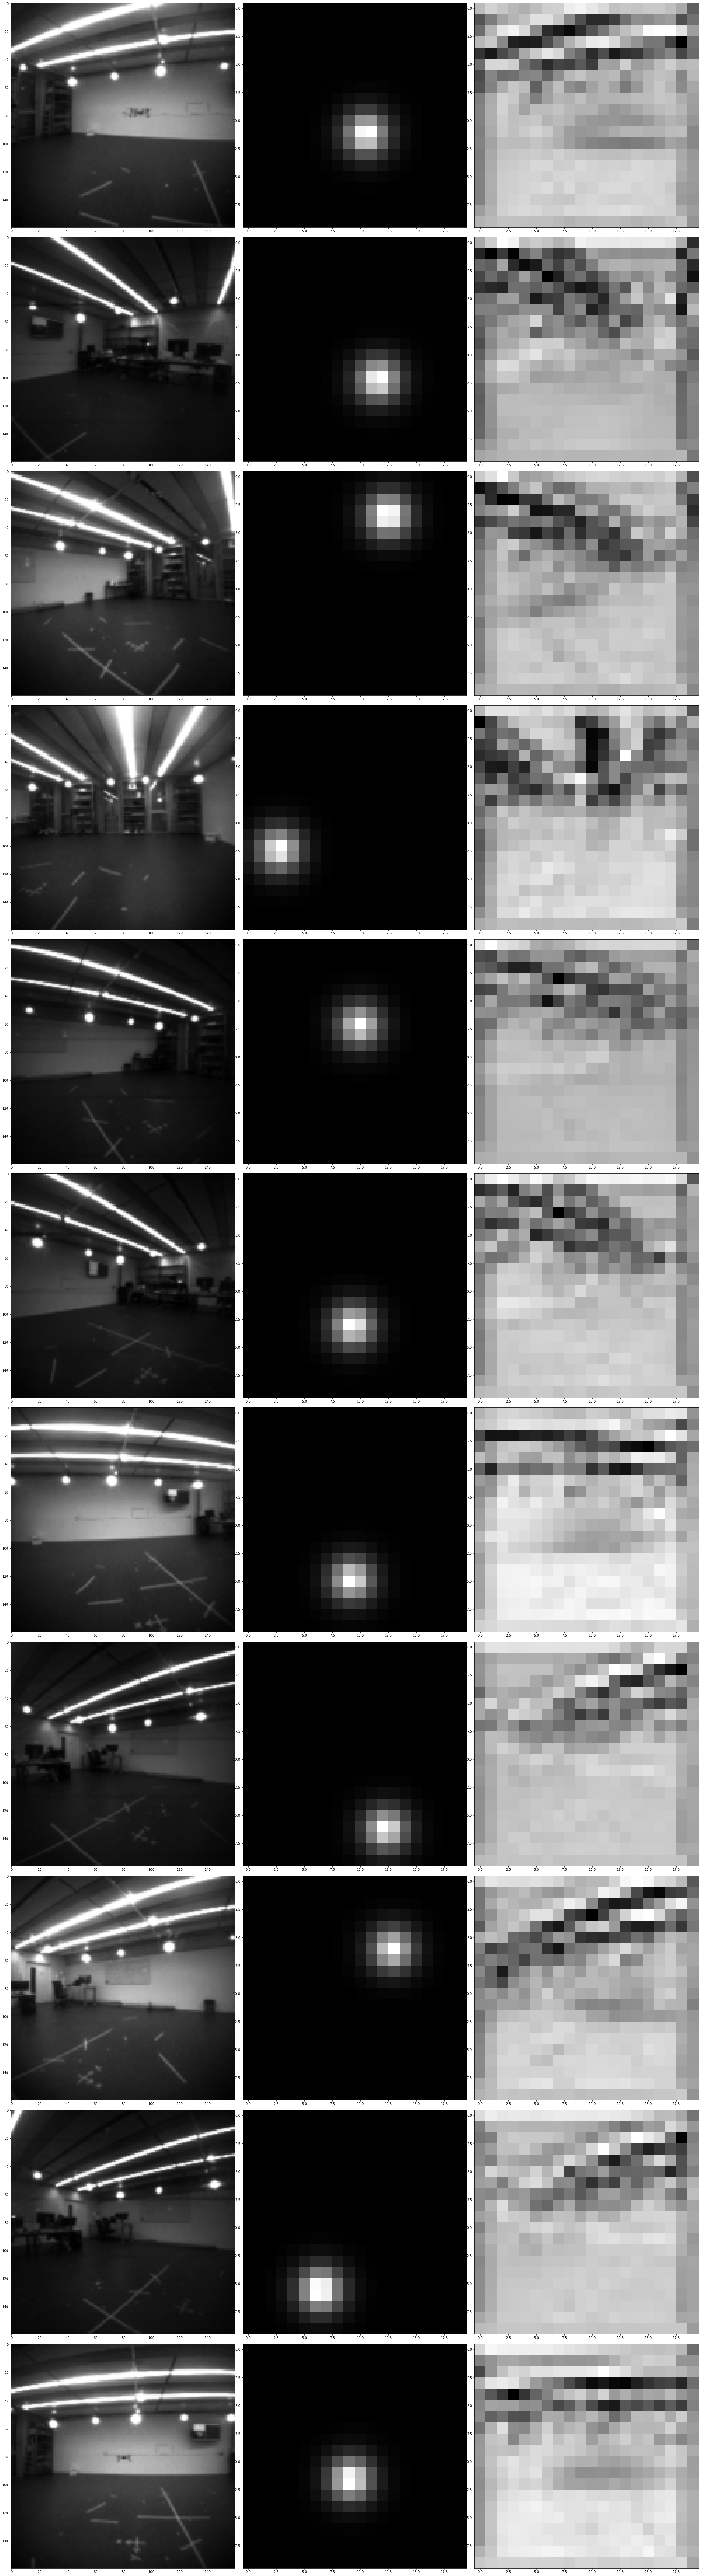

In [15]:
test_loss = 0.0
correct = 0
total = 0
model.eval()  # set model to evaluation mode

fig_in, ax_in = plt.subplots(11, 3, figsize=(30, 110))
ax_in = ax_in.flatten()

with torch.no_grad():
    # get a single batch of data from test dataloader
    data = next(iter(calib_dataloader))
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs.float() / 255.0)
    outputs = outputs * torch.tensor([1., 1., 3.]).view(1, 3, 1, 1).to(outputs.device)
    loss = total_loss(outputs, labels)
    test_loss += loss.item()
    pos_true, led_true, dis_true, pos_pred, led_pred, dis_pred = decompose(labels,outputs)
    for i in range(0,inputs.shape[0],3):
        ax_in[i].imshow(inputs[i][0].cpu(),cmap="gray")
        ax_in[i+1].imshow(pos_true[i].cpu(),cmap="gray")
        ax_in[i+2].imshow(pos_pred[i].cpu(),cmap="gray")
    #   

print(f"Test loss: {test_loss}")

plt.tight_layout()
plt.show()

In [16]:
def validate(model, device, dataloader, verbose=True, integer=False):
    correct = 0
    total = 0
    test_loss = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            if integer:
                outputs = model(inputs.float())
            else:
                outputs = model(inputs.float() / 255.0)
            outputs = outputs * torch.tensor([1., 1., 3.]).view(1, 3, 1, 1).to(outputs.device)
            loss = total_loss(outputs, labels)
            test_loss += loss.item()
        print(f"Test loss: {test_loss/len(dataloader)}")
    return test_loss/len(dataloader)

In [17]:
import quantlib
import quantlib.algorithms as qa
import quantlib.editing.graphs as qg
import quantlib.editing.editing as qe
import quantlib.backends.dory as qd

In [18]:
#@title Trace floating-point model graph and print it in human-readable format

# Symbolic trace of the graph
model_fp = qg.fx.quantlib_symbolic_trace(root=model)

# Print the graph in tabular format
model_fp.graph.print_tabular()

opcode       name       target     args          kwargs
-----------  ---------  ---------  ------------  --------
placeholder  x          x          ()            {}
call_module  conv1      conv1      (x,)          {}
call_module  bn1        bn1        (conv1,)      {}
call_module  relu1      relu1      (bn1,)        {}
call_module  sep_conv1  sep_conv1  (relu1,)      {}
call_module  bn2        bn2        (sep_conv1,)  {}
call_module  relu2      relu2      (bn2,)        {}
call_module  pool1      pool1      (relu2,)      {}
call_module  sep_conv2  sep_conv2  (pool1,)      {}
call_module  bn3        bn3        (sep_conv2,)  {}
call_module  relu3      relu3      (bn3,)        {}
call_module  pool2      pool2      (relu3,)      {}
call_module  sep_conv3  sep_conv3  (pool2,)      {}
call_module  bn4        bn4        (sep_conv3,)  {}
call_module  relu4      relu4      (bn4,)        {}
call_module  pool3      pool3      (relu4,)      {}
call_module  sep_conv4  sep_conv4  (pool3,)      {}
ca

In [19]:
#float 2 fake
f2fconverter = qe.float2fake.F2F8bitPACTRoundingConverter()
model_fq = f2fconverter(model_fp)
# set validation state
model_fq.eval()


MkModel(
  (conv1): PACTConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): PACTReLU()
  (sep_conv1): PACTConv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): PACTReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sep_conv2): PACTConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): PACTReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sep_conv3): PACTConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): PACTRe

In [20]:
# Print the graph in tabular format
model_fq.graph.print_tabular()

opcode       name       target     args          kwargs
-----------  ---------  ---------  ------------  --------
placeholder  x          x          ()            {}
call_module  conv1      conv1      (x,)          {}
call_module  bn1        bn1        (conv1,)      {}
call_module  relu1      relu1      (bn1,)        {}
call_module  sep_conv1  sep_conv1  (relu1,)      {}
call_module  bn2        bn2        (sep_conv1,)  {}
call_module  relu2      relu2      (bn2,)        {}
call_module  pool1      pool1      (relu2,)      {}
call_module  sep_conv2  sep_conv2  (pool1,)      {}
call_module  bn3        bn3        (sep_conv2,)  {}
call_module  relu3      relu3      (bn3,)        {}
call_module  pool2      pool2      (relu3,)      {}
call_module  sep_conv3  sep_conv3  (pool2,)      {}
call_module  bn4        bn4        (sep_conv3,)  {}
call_module  relu4      relu4      (bn4,)        {}
call_module  pool3      pool3      (relu4,)      {}
call_module  sep_conv4  sep_conv4  (pool3,)      {}
ca

In [ ]:
# collect statistics about the floating-point `Tensor`s passing through the quantisers, so that we can better fit the quantisers' hyper-parameters
with qe.float2fake.calibration(model_fq):
    acc = validate(model_fq, device, calib_dataloader)

# adds rounding to all PACT operators
rounder =  qe.float2fake.F2F8bitPACTRounder()
model_fq_rounded = rounder(model_fq)

model_fq_rounded.to(device)
model_fq_rounded.eval()

In [ ]:
model_fq.graph.print_tabular()

In [ ]:
valid_set = get_data("./content/datasets/dataset_test.h5",False,False,1024)
# valid_set = get_data("./content/datasets/dataset_test.h5",False,False,0)
valid_dataset = MyDataset(valid_set[0], valid_set[1])
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [ ]:
# get exaple input
x, _ = next(iter(valid_dataloader))
x = x[0].unsqueeze(0)
print(x.dtype)

# convert to TrueQuantized with default 24-bit converter
f2tconverter = qe.f2t.F2T24bitConverter()
model_tq = f2tconverter(model_fq_rounded, {'x': {'shape': x.shape, 'scale': torch.tensor((0.0039216,))}})

In [ ]:
# Print the graph in tabular format
model_tq.graph.print_tabular()

In [ ]:
epsremover = qe.f2t.FinalEpsTunnelRemover()
model_tq_removed = epsremover(model_tq)
print(model_tq_removed)

In [ ]:
doryexporter = qd.DORYExporter()
doryexporter.export(model_tq, x.shape, ".")
doryexporter.dump_features(model_tq, x, ".")

In [ ]:
mgX40, mgY40 = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))
def postprocess_simple_batch(labels, outputs):
    pos_true, led_true, dis_true, pos_predi, led_predi, dis_predi = decompose(labels,outputs)
    pos_truei=pos_true.cpu().detach().numpy()
    led_truei=led_true.cpu().detach().numpy()
    dis_truei=dis_true.cpu().detach().numpy()
    pos_predi=pos_predi.cpu().detach().numpy()
    led_predi=led_predi.cpu().detach().numpy()
    dis_predi=dis_predi.cpu().detach().numpy()

    # a=dis_pred[i]*pos_pred[i]
    # a=a.cpu().detach().numpy()
    # b=pos_pred[i].cpu().detach().numpy()
    # dis_pred_val = np.sum(a)/np.sum(b)
    threshold = np.max(pos_predi, axis = (1,2), keepdims = True) * .4
    # print(threshold)
    pos_predi -= threshold
    np.clip(pos_predi, 0, threshold, out = pos_predi)
    pos_predj=pos_predi
    # print(np.sum(dis_predi * pos_predi, axis=(1,2))/np.sum(pos_predi, axis=(1,2)))
    # print(np.sum(dis_truei * pos_truei, axis=(1,2))/np.sum(pos_truei, axis=(1,2)))
  
    
    # print(dis_true)
    ret = dict(
        x_pred = np.sum(mgX40[np.newaxis,:,:] * pos_predi, axis=(1,2))/np.sum(pos_predi, axis=(1,2)) * 160,
        y_pred = np.sum(mgY40[np.newaxis,:,:] * pos_predi, axis=(1,2))/np.sum(pos_predi, axis=(1,2)) * 160,
        led_pred = np.sum(led_predi * pos_predj, axis=(1,2))/np.sum(pos_predj, axis=(1,2)),
        dis_pred = np.sum(dis_predi * pos_predj, axis=(1,2))/np.sum(pos_predj, axis=(1,2)),
        pred_confidence = np.max(pos_predi, axis=(1,2)),
        x_true = np.sum(mgX40[np.newaxis,:,:] * pos_truei, axis=(1,2))/np.sum(pos_truei, axis=(1,2)) * 160,
        y_true = np.sum(mgY40[np.newaxis,:,:] * pos_truei, axis=(1,2))/np.sum(pos_truei, axis=(1,2)) * 160,
        led_true = np.sum(led_truei * pos_truei, axis=(1,2))/np.sum(pos_truei, axis=(1,2)),
        dis_true = np.sum(dis_truei * pos_truei, axis=(1,2))/np.sum(pos_truei, axis=(1,2)),
    )
    return [dict(zip(ret,t)) for t in zip(*ret.values())]

In [ ]:
data_out = []
with torch.no_grad():
    for data in valid_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_tq_removed(inputs.float())
        outputs = outputs * torch.tensor([1., 1., 3.]).view(1, 3, 1, 1).to(outputs.device)
        data_out += postprocess_simple_batch(labels,outputs)

In [ ]:
import pandas as pd
df = pd.DataFrame(data_out)
df["y_zone"] = (df["y_true"]/320*3).astype(int)
df["pred_confidence_bin"] = (df["pred_confidence"]*2.99).astype(int)

In [ ]:
import sklearn
import sklearn.metrics
fig,axs = plt.subplots(ncols=3, figsize=(10,3))
alpha = 0.1
axs[0].scatter(df["x_true"],df["x_pred"], s=1, marker='.', alpha=alpha)
axs[0].plot([0,160],[0,160],'k:')
axs[0].set_title(f"u: R2 {sklearn.metrics.r2_score(df['x_true'],df['x_pred']):.03f}")
axs[1].scatter(df["y_true"],df["y_pred"], s=1, marker='.', alpha=alpha)
axs[1].plot([0,160],[0,160],'k:')
axs[1].set_title(f"v: R2 {sklearn.metrics.r2_score(df['y_true'],df['y_pred']):.03f}")
axs[2].scatter(df["dis_true"],df["dis_pred"]/(255*0.5), s=1, marker='.', alpha=alpha)
axs[2].plot([0.4,1.6],[0.4,1.6],'k:')
axs[2].set_title(f"d: R2 {sklearn.metrics.r2_score(df['dis_true'],df['dis_pred']/(255*0.5)):.03f}")

In [ ]:
import matplotlib
from matplotlib.pyplot import figure
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

matplotlib.rc('font', **font)
figure(figsize=(8,8), dpi=80)
plt.title("distance")
plt.xlim([0.2, 1.6])
plt.ylim([0.2, 1.6])
plt.plot(df["dis_true"],df["dis_true"], c ="green")
plt.scatter(df["dis_true"],df["dis_pred"]/(255*0.5), c ="red", alpha=0.1)
plt.show()
figure(figsize=(8,8), dpi=80)
plt.title("v image")
plt.xlim([0, 160])
plt.ylim([0, 160])
plt.plot(df["y_true"],df["y_true"], c ="green")
plt.scatter(df["y_true"], df["y_pred"], c ="red", alpha=0.1)
plt.show()
figure(figsize=(8,8), dpi=80)
plt.title("u image")
plt.xlim([0, 160])
plt.ylim([0, 160])
plt.plot(df["x_true"], df["x_true"], c ="green")
plt.scatter(df["x_true"], df["x_pred"], c ="red", alpha=0.1)
plt.show()

In [ ]:
test_set = get_data("./content/datasets_test_hard/dataset_test_hard.h5",False,False,0)
test_dataset = MyDataset(test_set[0], test_set[1])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
data_out = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_tq_removed(inputs.float())
        outputs = outputs * torch.tensor([1., 1., 3.]).view(1, 3, 1, 1).to(outputs.device)
        data_out += postprocess_simple_batch(labels,outputs)

In [ ]:
import pandas as pd
df = pd.DataFrame(data_out)
df["y_zone"] = (df["y_true"]/320*3).astype(int)
df["pred_confidence_bin"] = (df["pred_confidence"]*2.99).astype(int)

In [ ]:
import sklearn
import sklearn.metrics
fig,axs = plt.subplots(ncols=3, figsize=(10,3))
alpha = 0.1
axs[0].scatter(df["x_true"],df["x_pred"], s=1, marker='.', alpha=alpha)
axs[0].plot([0,160],[0,160],'k:')
axs[0].set_title(f"u: R2 {sklearn.metrics.r2_score(df['x_true'],df['x_pred']):.03f}")
axs[1].scatter(df["y_true"],df["y_pred"], s=1, marker='.', alpha=alpha)
axs[1].plot([0,160],[0,160],'k:')
axs[1].set_title(f"v: R2 {sklearn.metrics.r2_score(df['y_true'],df['y_pred']):.03f}")
axs[2].scatter(df["dis_true"],df["dis_pred"], s=1, marker='.', alpha=alpha)
axs[2].plot([0.4,1.6],[0.4,1.6],'k:')
axs[2].set_title(f"d: R2 {sklearn.metrics.r2_score(df['dis_true'],df['dis_pred']/(255*0.5)):.03f}")

In [ ]:
import matplotlib
from matplotlib.pyplot import figure
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

matplotlib.rc('font', **font)
figure(figsize=(8,8), dpi=80)
plt.title("distance")
plt.xlim([0.2, 1.6])
plt.ylim([0.2, 1.6])
plt.plot(df["dis_true"],df["dis_true"], c ="green")
plt.scatter(df["dis_true"],df["dis_pred"]/(255*0.5), c ="red", alpha=0.1)
plt.show()
figure(figsize=(8,8), dpi=80)
plt.title("v image")
plt.xlim([0, 160])
plt.ylim([0, 160])
plt.plot(df["y_true"],df["y_true"], c ="green")
plt.scatter(df["y_true"], df["y_pred"], c ="red", alpha=0.1)
plt.show()
figure(figsize=(8,8), dpi=80)
plt.title("u image")
plt.xlim([0, 160])
plt.ylim([0, 160])
plt.plot(df["x_true"], df["x_true"], c ="green")
plt.scatter(df["x_true"], df["x_pred"], c ="red", alpha=0.1)
plt.show()